In [103]:
import numpy as np # Deals with array
import pandas as pd # Deals with data
import torch # Pytorch lib
import torch.nn as nn # Neural net lib
from torch.autograd import Variable # Deals with mathematical functions like differentiation, etc
import yfinance as yf # Yahoo finance api to get historical financial data
import matplotlib.pyplot as plt # Used to plot graphs
import mplfinance as mpl # Used to plot graph of financial data
from sklearn.model_selection import train_test_split # Used to split data into training and testing one
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Used for preprocessing of data

In [104]:
df = yf.download("ETH-USD")

[*********************100%%**********************]  1 of 1 completed


In [145]:
df.tail(224) # This will be our testing data time interval (according to the shape of the testing data)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-14,1796.107910,1823.490723,1793.228760,1800.500977,1800.500977,4711210241
2023-05-15,1800.371216,1845.695435,1787.536377,1817.549927,1817.549927,6748889346
2023-05-16,1816.824219,1830.351562,1797.843750,1824.121460,1824.121460,5595959668
2023-05-17,1824.068359,1835.554565,1786.671997,1821.859619,1821.859619,6352161579
2023-05-18,1822.068237,1831.450317,1774.195068,1801.728516,1801.728516,5673124255
...,...,...,...,...,...,...
2023-12-19,2218.240967,2253.348877,2139.723389,2177.872559,2177.872559,10619179629
2023-12-20,2177.239502,2263.329102,2161.218750,2201.911377,2201.911377,12652290807
2023-12-21,2201.790039,2278.121582,2184.856689,2239.542480,2239.542480,12616530536


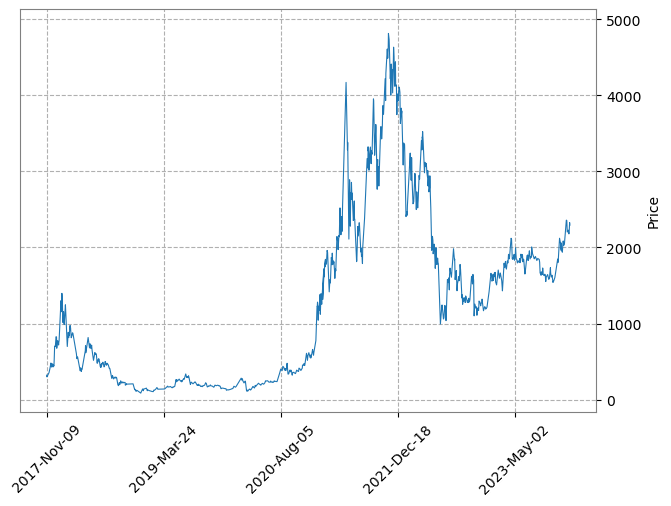

In [137]:
mpl.plot(df, type="line", style="tradingview")

In [107]:
# Splitting the data into testing data and training data in the range of 0-1 as numpy arrays.

y = df[['Close']]
X = df.drop(['Close'], axis=1, inplace=False) #axis 1 is column

mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_ss, y_mm, train_size= 0.9, test_size=0.1, shuffle=False)

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (2012, 5) (2012, 1)
Testing Shape (224, 5) (224, 1)


In [108]:
#converting numpy array into tensors

X_train_tensor = Variable(torch.Tensor(X_train))
X_test_tensor = Variable(torch.Tensor(X_test))

y_train_tensor = Variable(torch.Tensor(y_train))
y_test_tensor = Variable(torch.Tensor(y_test))

X_train_tensor

tensor([[-0.8272, -0.8168, -0.8204, -0.8172, -1.0970],
        [-0.8165, -0.8209, -0.8320, -0.8365, -1.0977],
        [-0.8362, -0.8255, -0.8286, -0.8227, -1.1020],
        ...,
        [ 0.5445,  0.4984,  0.5359,  0.5029, -0.3631],
        [ 0.5022,  0.4723,  0.5066,  0.5132, -0.2949],
        [ 0.5140,  0.4755,  0.5492,  0.5026, -0.7277]])

In [109]:
# Reshaping data to rows, timestamps, features

X_train_tensor_final = torch.reshape(X_train_tensor, (X_train_tensor.shape[0], 1, X_train_tensor.shape[1]))

X_test_tensor_final = torch.reshape(X_test_tensor, (X_test_tensor.shape[0], 1, X_test_tensor.shape[1]))

print("Training Shape", X_train_tensor_final.shape, y_train_tensor.shape)
print("Testing Shape", X_test_tensor_final.shape, y_test_tensor.shape)

Training Shape torch.Size([2012, 1, 5]) torch.Size([2012, 1])
Testing Shape torch.Size([224, 1, 5]) torch.Size([224, 1])


In [110]:
# Making the model

class LSTM1(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.output_size = output_size #storing inputs
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 128) #Defining the layers of the model
        self.fc2 = nn.Linear(128, output_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        h = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        output, (h, c) = self.lstm(x, (h, c))
        hn = h.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [111]:
X.size # This is what the .size function do 

11180

In [112]:
# Instantiating the class LSTM1 object.

output_size = 1 # number feature will be output
input_size = 5 # number of features to input
hidden_size = 2 # number of hidden layers
num_layers = 1 # number of stacked lstm layers
seq_length= X_train_tensor_final.shape[1] # time period of the neuron cell

lstm1 = LSTM1(output_size, input_size, hidden_size, num_layers, seq_length)

In [130]:
# Let’s define the Loss function and optimizer.

learning_rate = 0.001 

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) # optimizer 

In [114]:
# Training the model for epoch number of times. 
# In each epoch the MSE of the model will be calculated 
# and backpropagation(complex calculations) will be done to reduce the MSE of next epoch

num_epochs= 1000

for epoch in range(num_epochs):
    outputs = lstm1(X_train_tensor_final) # output = predictions on the training data
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensor) # calculates the MSE of the predicted value
    loss.backward()
    optimizer.step() # improve from loss using back propagation
    if epoch % 100 == 0: # if the remainder of epoch divided by 100 is 0 / if epoch is divisible by 100
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.19530
Epoch: 100, loss: 0.03182
Epoch: 200, loss: 0.00687
Epoch: 300, loss: 0.00061
Epoch: 400, loss: 0.00029
Epoch: 500, loss: 0.00021
Epoch: 600, loss: 0.00017
Epoch: 700, loss: 0.00014
Epoch: 800, loss: 0.00012
Epoch: 900, loss: 0.00010


In [133]:
# Now let's test the model on the testing data

prediction = lstm1(X_test_tensor_final)

prediction_data = prediction.data.numpy() # tensor to numpy array conversion
prediction_data = mm.inverse_transform(prediction_data)
actual_data = y_test_tensor.data.numpy()
actual_data = mm.inverse_transform(actual_data)

In [135]:
# Calculating the Mean Squared Error of the model

loss = criterion(prediction, y_test_tensor)
print(loss)

tensor(0.0002, grad_fn=<MseLossBackward0>)


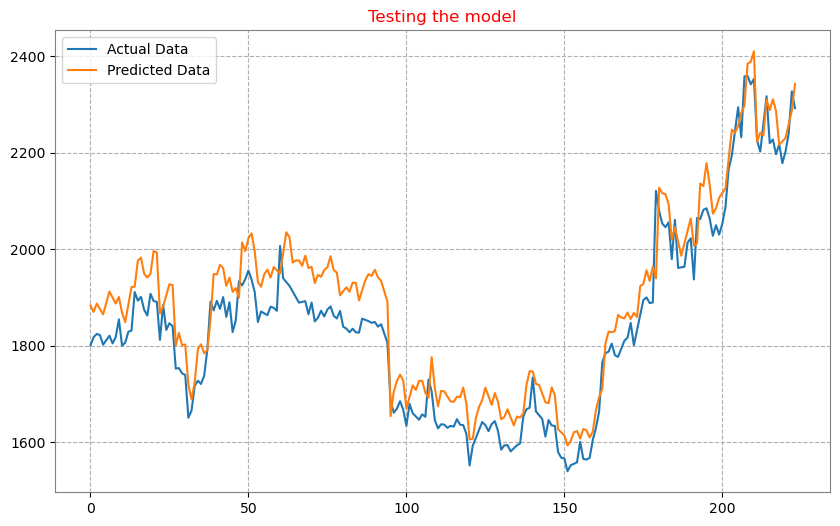

In [128]:
# Plotting the predictions that were made on the testing data

plt.figure(figsize=(10,6)) #plotting

plt.plot(actual, label='Actual Data') #actual plot
plt.plot(prediction, label='Predicted Data') #predicted plot
plt.title('Testing the model')
plt.legend()
plt.show() 

In [176]:
# Making a dataframe to store the predicted price data according to the its datetime

prediction_datetime_index = pd.date_range(start='2023-05-14', end='2023-12-23', freq='D')
prediction_df = pd.DataFrame(index=prediction_datetime_index, columns=['Predicted_Close'])
prediction_data_flat = prediction_data.flatten()
prediction_df['Predicted_Close'] = prediction_data
prediction_df.head()

,Predicted_Close
2023-05-14,1883.158081
2023-05-15,1869.694580
2023-05-16,1887.000610
2023-05-17,1873.967285
2023-05-18,1864.700073


Text(0, 0.5, 'Closing price - USD')

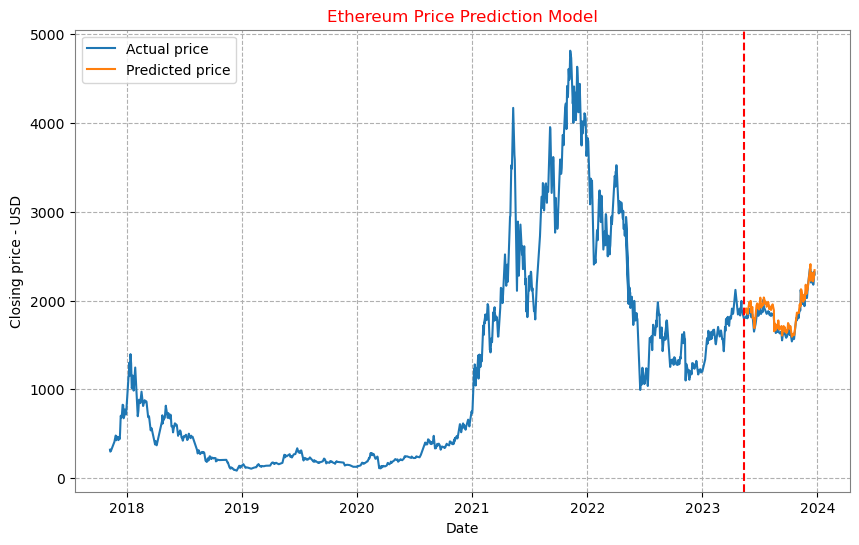

In [196]:
# Plotting the overall graph

plt.figure(figsize=(10,6))
plt.plot(df.index, df['Close'], label= "Actual price")
plt.plot(prediction_df.index, prediction_df['Predicted_Close'], label ="Predicted price")
plt.axvline(x=pd.to_datetime('2023-05-14'), c='r', linestyle='--')
plt.legend()
plt.title("Ethereum Price Prediction Model")
plt.xlabel("Date")
plt.ylabel("Closing price - USD")